In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import textwrap
from scipy.stats import entropy

In [102]:
# Load the data
df_pbs = pd.read_csv('../pbs_c/cmake-build-debug/pbsBlocks.csv')
df_cmp = pd.read_csv('../pbs_c/cmake-build-debug/comparison.csv')

In [103]:
df_pbs.describe()

,Block Number,Proposer ID,Builder ID,Winning Bid Value,Winning Block Value,Reward,Builder ID 1 Bid,Builder ID 2 Bid,Builder ID 3 Bid,Builder ID 4 Bid,...,Builder ID 1 Block Value,Builder ID 2 Block Value,Builder ID 3 Block Value,Builder ID 4 Block Value,Builder ID 5 Block Value,Builder ID 10 Block Value,Builder ID 30 Block Value,Builder ID 50 Block Value,Builder ID 70 Block Value,Builder ID 90 Block Value
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2500.500000,26.447400,54.478400,431.937737,501.771549,209.795791,54.324077,55.336943,40.159451,44.043340,...,282.796576,277.646575,258.113201,261.740889,262.328967,316.007503,315.415175,339.601827,317.821700,516.257821
std,1443.520003,30.676718,36.633683,102.363677,127.339946,188.707388,130.043028,131.688488,112.399585,117.442512,...,122.437939,123.826860,116.305219,119.098887,121.332485,127.142244,125.306145,130.590143,124.481443,133.039847
min,1.000000,1.000000,1.000000,0.000000,14.153000,0.035691,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1250.750000,3.000000,10.000000,385.286500,437.966250,53.572700,0.000000,0.000000,0.000000,0.000000,...,196.089750,189.631750,173.673000,178.596000,172.484500,226.678250,228.715250,247.564000,232.121500,425.619250
50%,2500.500000,10.000000,70.000000,441.884500,507.971500,141.059500,0.000000,0.000000,0.000000,0.000000,...,278.089000,273.935000,252.890500,254.779500,254.258000,315.222000,316.706500,337.434500,317.234500,516.859000
75%,3750.250000,50.000000,90.000000,486.804750,580.097000,346.337000,0.000000,0.000000,0.000000,0.000000,...,363.453000,357.911250,335.288250,339.127000,345.087750,403.184750,402.645250,431.472750,403.320000,608.946750
max,5000.000000,90.000000,90.000000,849.817000,908.536000,849.817000,614.011000,591.675000,526.869000,607.042000,...,721.745000,711.356000,792.040000,742.080000,725.171000,774.024000,777.959000,768.451000,739.376000,916.257000


In [104]:
def get_builder_type(id):
    if 1 <= id <= 9:
        return 'Normal Proposer Builder'
    elif 10 <= id <= 999:
        return 'MEV Proposer Builder'
    else:
        return 'Unknown Builder'

def adjust_builder_id(id):
    if(get_builder_type(id) == 'MEV Proposer Builder'):
        return int(int(id) / 20 + 1)
    else:
        return id

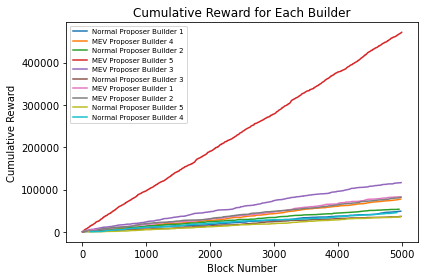

In [105]:
builder_ids = df_pbs['Builder ID'].unique()
fig, axs = plt.subplots()
for builder_id in builder_ids:
    builder_df_pbs = df_pbs[df_pbs['Builder ID'] == builder_id]
    cumulative_rewards = np.cumsum([reward for reward, id in zip(df_pbs['Reward'], df_pbs['Builder ID']) if id == builder_id])
    axs.plot(builder_df_pbs['Block Number'].values, cumulative_rewards, label=f'{get_builder_type(builder_id)} {adjust_builder_id(builder_id)}')

axs.set_title('Cumulative Reward for Each Builder')
axs.set_xlabel('Block Number')
axs.set_ylabel('Cumulative Reward')
axs.legend(loc='best',prop={'size': 7})
plt.tight_layout()
plt.show()

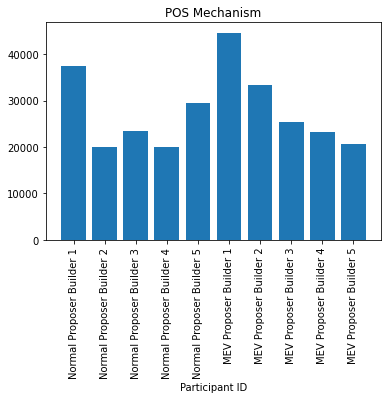

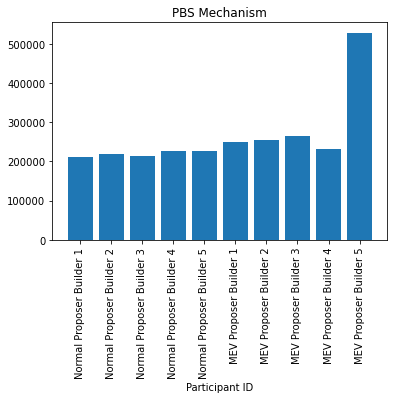

In [106]:
total_rewards_pos = []
total_rewards_pbs = []
builder_ids = np.sort(df_pbs['Builder ID'].unique())

for builder_id in builder_ids:
    cumulative_rewards_pbs = ([reward for reward, id, b_id in zip(df_pbs['Reward'], df_pbs['Builder ID'],df_pbs['Proposer ID']) if id == builder_id & id != b_id]+
                             [bid for bid, id in zip(df_pbs['Winning Bid Value'], df_pbs['Proposer ID']) if id == builder_id])
    total_rewards_pbs.append(sum(cumulative_rewards_pbs))

    cumulative_rewards_pos = [reward for reward, id in zip(df_cmp['POS Block Value'], df_cmp['POS Builder ID']) if id == builder_id]
    total_rewards_pos.append(sum(cumulative_rewards_pos))


builder_labels = [f'{get_builder_type(builder_id)} {adjust_builder_id(builder_id)}' for builder_id in builder_ids]
plt.bar(builder_labels, total_rewards_pos)
plt.title('POS Mechanism')
plt.xlabel('Participant ID')
plt.xticks(rotation=90) 
plt.show()

plt.bar(builder_labels, total_rewards_pbs)
plt.title('PBS Mechanism')
plt.xlabel('Participant ID')
plt.xticks(rotation=90) 
plt.show()



In [107]:
def gini(x):
    """Compute Gini coefficient of array of values"""
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))

In [108]:
#this is for homogenous builders, 5 extra nodes, 10000 blocks. 
gini_pbs = gini(np.array(total_rewards_pbs))
gini_pos = gini(np.array(total_rewards_pos))

print(f'Gini coefficient for PBS rewards: {gini_pbs}')
print(f'Gini coefficient for POS rewards: {gini_pos}')

Gini coefficient for PBS rewards: 0.13165858163615327
Gini coefficient for POS rewards: 0.154026755831973


In [109]:
# Herfindahl-Hirschman Index (HHI) 
def hhi(x):
    """Compute Herfindahl-Hirschman Index of array of values"""
    return (x**2).sum() / (x.sum())**2

hhi_pos = hhi(np.array(total_rewards_pos))
hhi_pbs = hhi(np.array(total_rewards_pbs))

print(f"HHI for PBS: {hhi_pbs}")
print(f"HHI for POS: {hhi_pos}")

HHI for PBS: 0.11180398448303323
HHI for POS: 0.10813496071221117


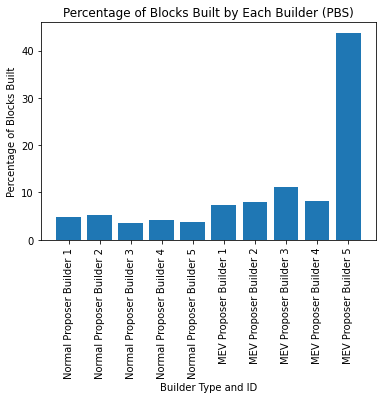

In [110]:
block_counts = [len(df_pbs[df_pbs['Builder ID'] == builder_id]) for builder_id in builder_ids]
block_percentages = [count / len(df_pbs) * 100 for count in block_counts]

plt.bar(builder_labels, block_percentages)
plt.title('Percentage of Blocks Built by Each Builder (PBS)')
plt.xlabel('Builder Type and ID')
plt.ylabel('Percentage of Blocks Built')
# Rotate the x-axis labels
plt.xticks(rotation=90) 
plt.show()
